In [658]:
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
import time
import torch.nn.functional as F
import seaborn as sns

In [704]:
X = pd.read_csv('X_train.csv')
y = pd.read_csv('y_train.csv')

In [660]:
df = X.copy()
df['target'] = y['diabettes in 5 years']

<AxesSubplot:>

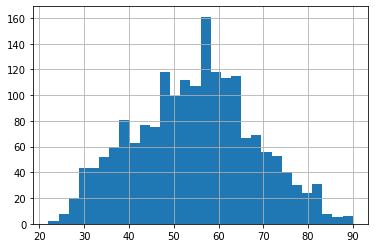

In [661]:
df[df['target'] == 1]['Age'].hist(bins=30)

In [705]:
def preprocessing_X(X, y=None):
    X = X.join(pd.get_dummies(X['Gender']).rename(columns={1 : 'Male', 2 : 'Female'}))
    X = X.drop(columns = ['Gender'])
    X = X.join(pd.get_dummies(X['site'], prefix='site'))
    X = X.drop(columns = ['site'])
    X = X.join(pd.get_dummies(X['smoking status'], prefix='smoking status'))
    X = X.drop(columns = ['smoking status'])
    X = X.join(pd.get_dummies(X['drinking status'], prefix='drinking status'))
    X = X.drop(columns = ['drinking status'])

    analysis = ['height', 'weight', 'Body Mass Index', 'Systolic blood pressure',
           'diastolic blood pressure', 'Fasting plasma glucose', 'Cholesterol',
           'Triglyceride', 'High-density lipoprotein cholesterol ',
           'Low-density lipoprotein cholesterol', 'Alanine aminotransferase',
           'Aspartate transaminase', 'Blood urea nitrogen',
           'Creatinine clearance rate']

    for name in analysis:
        mean_value = X[name].mean()
        X[name].fillna(mean_value, inplace=True)
    if y is not None:
        X['target'] = y['diabettes in 5 years']
    
    def multiply_rows(X):
        X_copy = X.copy()
        X_copy['years_during_start'] = X_copy['year of followup'].astype(int)
        for i in range(6):
            X_copy = X_copy.append([X_copy[X_copy['years_during_start'] == i]] * i, ignore_index=True)
        X_copy.drop(columns=['years_during_start'])
        return X_copy
        
    #X = multiply_rows(X)
    return X

In [706]:
X = preprocessing_X(X, y)

In [707]:
def drop_secret_data(X):
    return X.drop(columns=['Fasting plasma glucose (final visit)',
       'Diabetes diagnosed during followup', 'censor of diabetes at followup',
       'year of followup', 'target']), X['target']

X, y = drop_secret_data(X)

In [708]:
y = y.drop(columns=['Id'])

In [709]:
X = np.array(X)
y = np.array(y).reshape(-1)

In [710]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [668]:
def compute_loss(X, y):
    X = torch.FloatTensor(X).to(device=device)
    y = torch.LongTensor(y).to(device=device)
    logits = net.to(device)(X)
    logits = torch.cat((1 - logits, logits), dim=1)
    return F.cross_entropy(logits, y).mean()

In [669]:
def compute_log_loss(X, y):
    X = torch.FloatTensor(X).to(device=device)
    y = torch.LongTensor(y).to(device=device)
    logits = net.to(device)(X)
    logits = torch.cat((1 - logits, logits), dim=1)
    return metrics.log_loss(y, logits.data)

In [670]:
def get_predict(X):
    X_batch = torch.FloatTensor(X).to(device=device)
    logits = net.to(device)(X_batch)
    return logits

In [671]:
# batch generator
def get_batches(X, Y, batch_size):
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]


In [672]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
net.to(device)
device

device(type='cpu')

In [673]:
net = nn.Sequential(
    nn.BatchNorm1d(X.shape[1]),
    #nn.Linear(X.shape[1], X.shape[1]),
    #nn.LeakyReLU(),
    #nn.Linear(X.shape[1], 10),
    #nn.LeakyReLU(),
    nn.Linear(X.shape[1], 1),
    nn.Sigmoid()
)

def train_net(X_train, y_train, net):
    opt = torch.optim.SGD(net.parameters(), lr=0.001)

    train_loss = []
    val_accuracy = []

    num_epochs = 50
    
    # total amount of full passes over training data

    batch_size = 100

    for epoch in range(num_epochs):
        start_time = time.time()
        net.train(True) # enable dropout / batch_norm training behavior
        batch_num = 0
        for (X_batch, y_batch) in get_batches(X_train, y_train, batch_size):
            # train on batch
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            opt.zero_grad()
            train_loss.append(loss.cpu().data.numpy())
            batch_num += 1
        net.train(False) # disable dropout / use averages for batch_norm
        val_loss = compute_loss(X_val, y_val).data.numpy()


        # Then we print the results for this epoch:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(X_train) // batch_size :])))
        print('  validation loss: \t\t\t{:.6f}'.format(val_loss))

In [674]:
train_net(X_train, y_train, net)

Epoch 1 of 50 took 0.455s
  training loss (in-iteration): 	0.674600
  validation loss: 			0.652658
Epoch 2 of 50 took 0.456s
  training loss (in-iteration): 	0.634836
  validation loss: 			0.618016
Epoch 3 of 50 took 0.488s
  training loss (in-iteration): 	0.600136
  validation loss: 			0.583031
Epoch 4 of 50 took 0.458s
  training loss (in-iteration): 	0.570086
  validation loss: 			0.559343
Epoch 5 of 50 took 0.461s
  training loss (in-iteration): 	0.544245
  validation loss: 			0.534232
Epoch 6 of 50 took 0.455s
  training loss (in-iteration): 	0.521981
  validation loss: 			0.512424
Epoch 7 of 50 took 0.453s
  training loss (in-iteration): 	0.502757
  validation loss: 			0.495559
Epoch 8 of 50 took 0.453s
  training loss (in-iteration): 	0.486143
  validation loss: 			0.478716
Epoch 9 of 50 took 0.460s
  training loss (in-iteration): 	0.471689
  validation loss: 			0.465866
Epoch 10 of 50 took 0.441s
  training loss (in-iteration): 	0.459054
  validation loss: 			0.456080
Epoch 11 

In [675]:
y_pred_test = get_predict(X_test)

In [676]:
y_pred_test

tensor([[0.0295],
        [0.0241],
        [0.0273],
        ...,
        [0.0851],
        [0.0071],
        [0.0132]], grad_fn=<SigmoidBackward>)

In [677]:
compute_loss(X_test, y_test)

tensor(0.3468, grad_fn=<MeanBackward0>)

In [678]:
compute_log_loss(X_test, y_test)

0.10654159614015753

In [713]:
X_test_secret = pd.read_csv('X_test.csv')

In [303]:
def get_test_answers(net, X_test_secret):
    X_test_secret = preprocessing_X(X_test_secret)
    X_test_secret = np.array(X_test_secret)
    logits = net(torch.FloatTensor(X_test_secret))
    return [i[0] for i in logits.data]

In [304]:
y_pred_secret = get_test_answers(net, X_test_secret)

In [305]:
df = pd.DataFrame(y_pred_secret, columns=['Prediction'])
df.index.name = 'Id'

df.to_csv('answer2')

In [307]:
df


,Prediction
Id,
0,0.006234
1,0.005673
2,0.008223
3,0.002324
4,0.004066
...,...
111828,0.005171
111829,0.008698
111830,0.003041


In [335]:
list(net.parameters())[1]

Parameter containing:
tensor([ 0.1470, -0.0262,  0.0339, -0.2782, -0.4225,  0.2639, -0.5342, -0.4923,
         0.3574,  0.1944,  0.4711,  0.4847, -0.4667, -0.2146,  0.0274,  0.1775,
         0.0895,  0.0795,  0.6341,  0.1588, -0.2627,  0.4159,  0.4331,  0.1602,
         0.0883,  0.0154,  0.2545,  0.1657, -0.2966, -0.1604,  0.0561,  0.0104,
         0.1850,  0.3283,  0.1537,  0.0778, -0.2406, -0.0231,  0.1767],
       requires_grad=True)

In [312]:
net.parameters

<bound method Module.parameters of Sequential(
  (0): BatchNorm1d(39, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): Linear(in_features=39, out_features=1, bias=True)
  (2): Sigmoid()
)>

In [337]:
X

array([[ 53. , 163.5,  64.1, ...,   0. ,   0. ,   1. ],
       [ 26. , 156. ,  68.5, ...,   0. ,   0. ,   1. ],
       [ 40. , 152. ,  47. , ...,   0. ,   0. ,   1. ],
       ...,
       [ 34. , 173. ,  59.9, ...,   0. ,   0. ,   0. ],
       [ 32. , 187. ,  96. , ...,   0. ,   0. ,   0. ],
       [ 56. , 158.5,  67.1, ...,   0. ,   0. ,   0. ]])

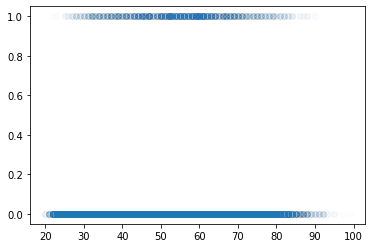

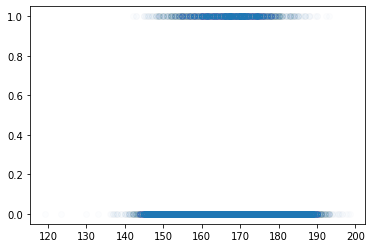

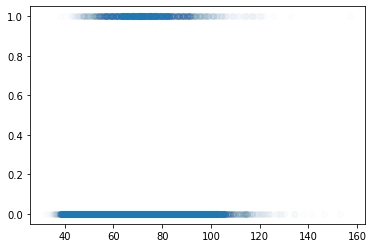

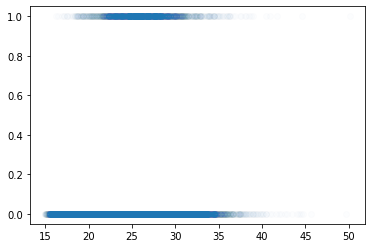

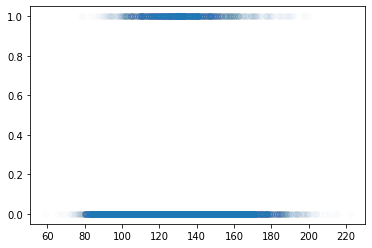

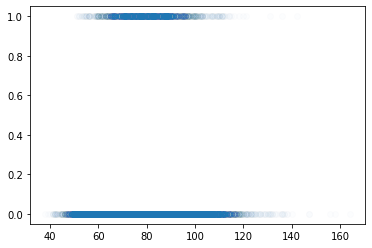

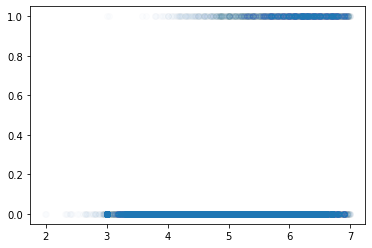

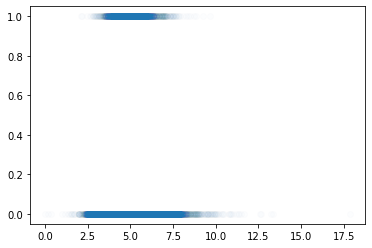

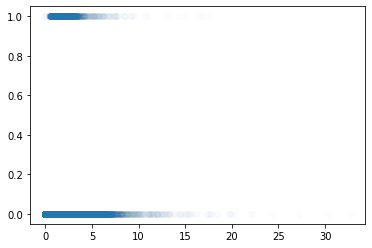

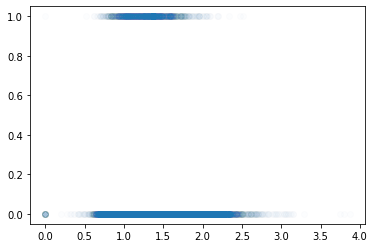

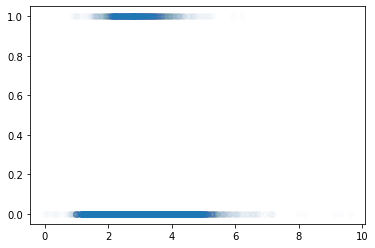

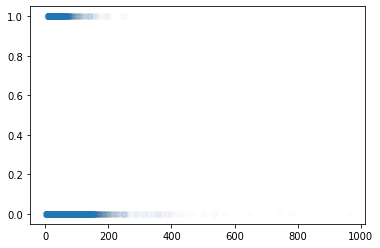

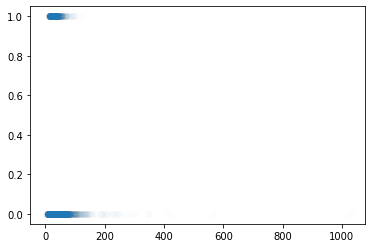

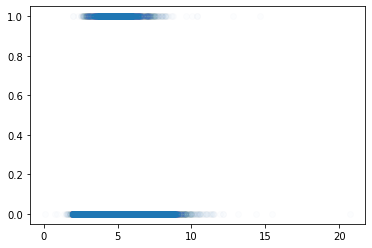

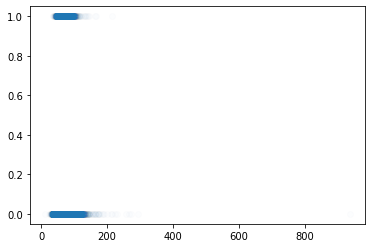

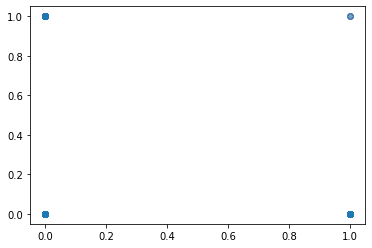

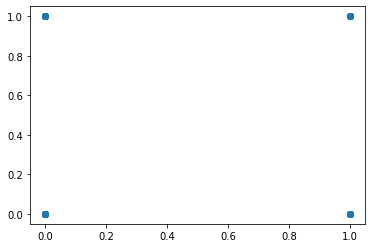

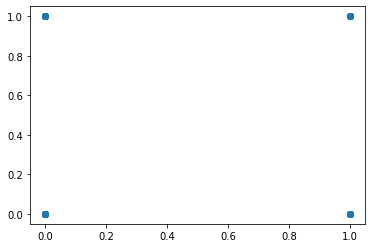

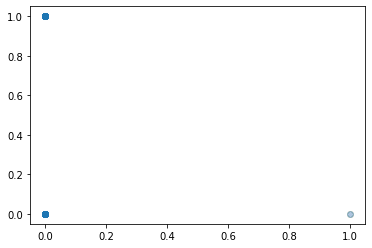

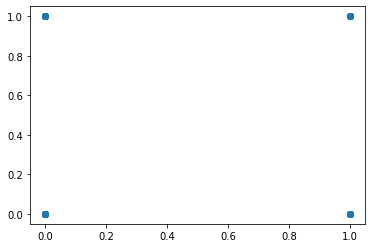

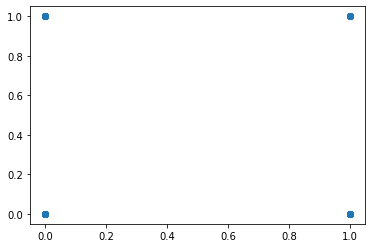

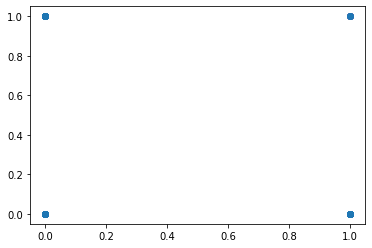

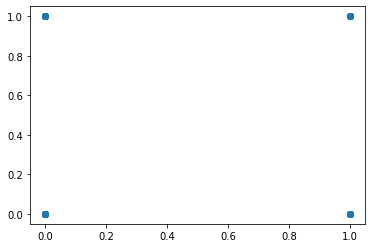

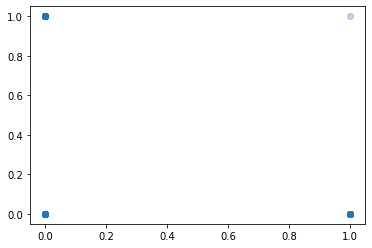

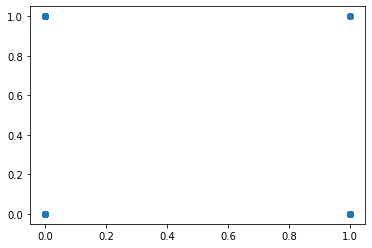

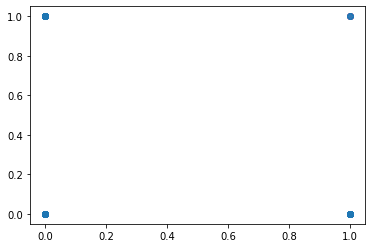

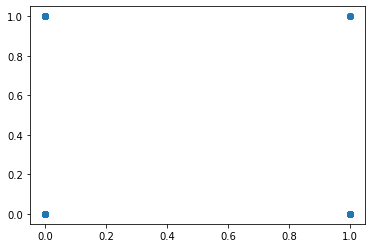

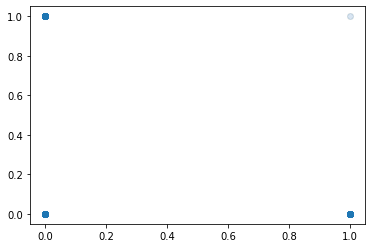

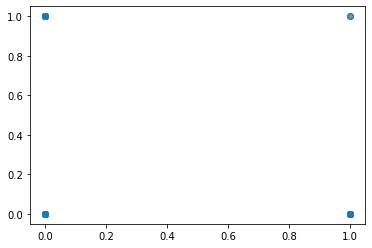

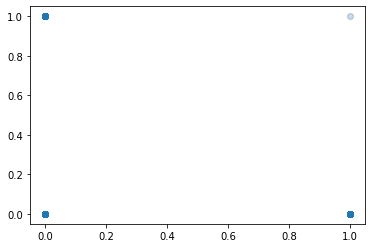

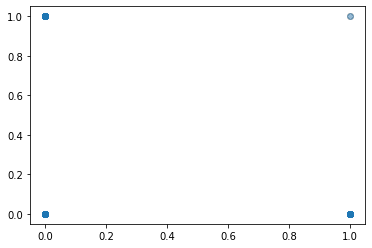

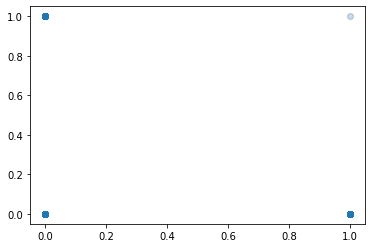

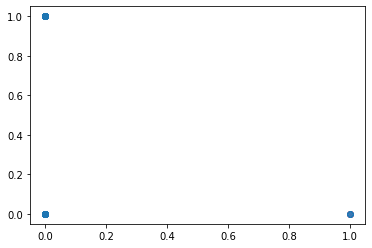

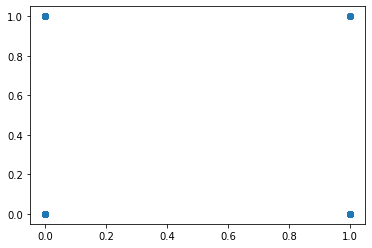

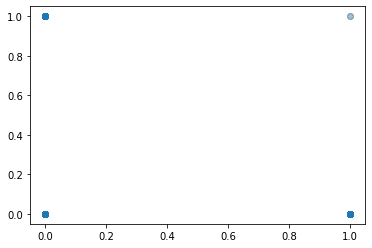

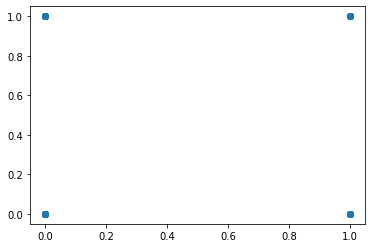

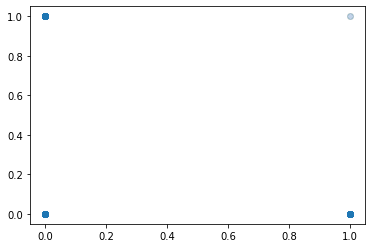

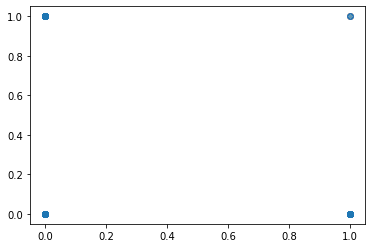

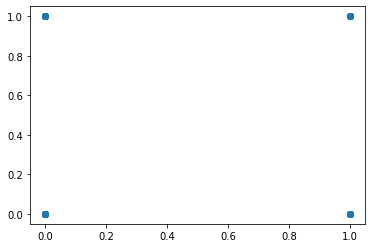

In [351]:
for name in X.columns:
    plt.scatter(X[name], y['diabettes in 5 years'], alpha=0.01)
    plt.show()
    

In [343]:
X.shape

(100000, 39)

In [344]:
y.shape

(100000, 2)

In [680]:
from sklearn import linear_model

In [711]:
LR = linear_model.LogisticRegression().fit(X_train, y_train)
y_pred = LR.predict_proba(X_test)
metrics.log_loss(y_test, y_pred[:, 1])

/home/captainbanana/virtual_envs/deep_learning/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.06003972925323829

In [714]:
X_test_secret = preprocessing_X(X_test_secret)
X_test_secret = np.array(X_test_secret)

In [715]:
y_pred_secret = LR.predict_proba(X_test_secret)

In [716]:
y_pred[:, 1]

array([0.0011406 , 0.00092532, 0.00313824, ..., 0.00465746, 0.00285811,
       0.00068376])

In [729]:
df = pd.DataFrame(y_pred_secret, columns=['Prediction'])
df.index.name = 'Id'

df.to_csv('answer3')

In [727]:
import statsmodels.api as sm
probit_model = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.probit()))
probit_results = probit_model.fit()


In [728]:
y_pred_secret = probit_results.predict(X_test_secret)

In [726]:
cloglog_model = sm.GLM(y_train, X_train, family=sm.families.Binomial(sm.families.links.cloglog()))
cloglog_results = probit_model.fit()
y_pred = cloglog_results.predict(X_test)
metrics.log_loss(y_test, y_pred)

0.058866179877414014